In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(42)
np.random.seed(42)
#tf.random.set_seed(42)

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

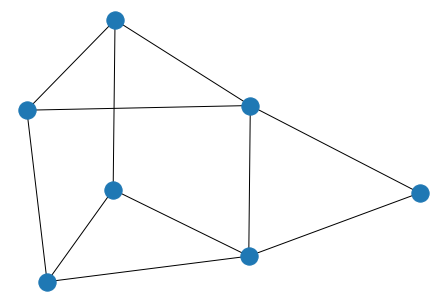

In [4]:

n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [5]:
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
#from qiskit.providers import aer
"""
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()
"""
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    #theta=theta.numpy
    print(theta)
    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep].item(), pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep].item(), i)
            
    qc.measure_all()
    #print(qc)
    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ
# Create an instance of a QAOA circuit given a graph.
#cost = qaoa_from_graph(graph=graphs[0], n_layers=1)



# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
#x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)
x=[0.5, 0.5]
#create_qaoa_circ(graphs[0],x)
#G=graphs[0]
#func=get_expectation(G, 1)
# Evaluate th QAOA instance just created with some angles.
#print(func(x))

In [240]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [40]:
#cell = torch.nn.LSTM(10,20,2)
#cell = torch.nn.LSTM(1,1,2)
cell = torch.nn.LSTM(3,2,1)
#cell = torch.nn.LSTM(1,1,1)
"""
input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
"""
#need tuple, tensor of shape (L,N,H_in)
#L=sequence length, N=batch size, H_in=input size
#https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

graph_cost_list = [get_expectation(g,1) for g in graphs]

In [41]:
from statistics import mean
def rnn_iteration(inputs, graph_cost, n_layers=1,requires_grad=True):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    
    """
    import torch

a = torch.randn(15, 200, 2048)
b = torch.randn(1, 200, 2048)

repeat_vals = [a.shape[0] // b.shape[0]] + [-1] * (len(b.shape) - 1)
# or directly repeat_vals = (15, -1, -1) or (15, 200, 2048) if shapes are known and fixed...
res = torch.cat((a, b.expand(*repeat_vals)), dim=-1)
print(res.shape)
# torch.Size([15, 200, 4096])
    """
    
    # Concatenate the previous parameters and previous cost to create new input
    #new_input = pytorch.cat([prev_cost, prev_params])
    print('params')

    prev_params=torch.reshape(prev_params,shape=(1,2))
    #new_input = torch.cat([prev_cost, prev_params])
    repeat_vals = [prev_cost.shape[0] // prev_params.shape[0]] + [-1] * (len(prev_params.shape) - 1)
    #repeat_vals = [prev_params.shape[0] // prev_cost.shape[0]] + [-1] * (len(prev_cost.shape) - 1)
    # or directly repeat_vals = (15, -1, -1) or (15, 200, 2048) if shapes are known and fixed...
    print(prev_params.shape)
    print(prev_cost.shape)
    new_input = torch.cat((prev_cost, prev_params.expand(*repeat_vals)), dim=-1)
    #new_input = torch.cat((prev_params, prev_cost.expand(*repeat_vals)), dim=-1)

    print(prev_cost.shape)
    new_input=torch.reshape(new_input, shape=(1,1,3))
    prev_h=torch.reshape(prev_h, shape=(1,1,2))
    prev_c=torch.reshape(prev_c, shape=(1,1,2))
    #print(new_input)
     # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    #new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])
    #output, (hn, cn) = rnn(input, (h0, c0))
    new_params, (new_h, new_c) = cell(new_input, (prev_h, prev_c))
   # Reshape the parameters to correctly match those expected by PennyLane
    _params = torch.reshape(new_params, shape=(2, n_layers))
                                      
    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    #new_cost = torch.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))
    _cost=torch.tensor(_cost)
    new_cost = torch.reshape(_cost, shape=(1, 1))
    return [new_cost, new_params, new_h, new_c]

In [42]:
def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False,requires_grad=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = torch.zeros(1, 1)
    #need shape=?
    initial_params = torch.zeros(1, 2 * n_layers)
    initial_h = torch.zeros(1, 2 * n_layers)
    initial_c = torch.zeros(1, 2 * n_layers)

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    los=[0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    print(los)
    loss = torch.mean(torch.stack(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    )
    #torch.mean(torch.stack(my_list))
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [49]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""
    
    loss = recurrent_loop(graph_cost)
    loss.requires_grad=True
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss
    
"""
    with tf.GradientTape() as tape:
        print(tape)
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)
 
    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)
    #the inputs to grads are fine
    # Apply gradients and update the weights of the LSTM cell
    print(grads)
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss


loss = compute_loss(model, x)
optimizer.zero_grad()
loss.backward()
optimizer.step()


    def train_step(graph_cost):
 

    # Evaluates the cost function
    loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    loss.backward()
    grads = cell.trainable_weights.grad

    # Apply gradients and update the weights of the LSTM cell
  #  opt.apply_gradients(zip(grads, cell.trainable_weights))
    optim = torch.optim.SGD(cell.trainable_weights.parameters(), lr=1e-2, momentum=0.9)

    return loss
    """

'\n    with tf.GradientTape() as tape:\n        print(tape)\n        # Evaluates the cost function\n        loss = recurrent_loop(graph_cost)\n \n    # Evaluates gradients, cell is the LSTM cell defined previously\n    grads = tape.gradient(loss, cell.trainable_weights)\n    #the inputs to grads are fine\n    # Apply gradients and update the weights of the LSTM cell\n    print(grads)\n    opt.apply_gradients(zip(grads, cell.trainable_weights))\n    return loss\n\n\nloss = compute_loss(model, x)\noptimizer.zero_grad()\nloss.backward()\noptimizer.step()\n\n\n    def train_step(graph_cost):\n \n\n    # Evaluates the cost function\n    loss = recurrent_loop(graph_cost)\n\n    # Evaluates gradients, cell is the LSTM cell defined previously\n    loss.backward()\n    grads = cell.trainable_weights.grad\n\n    # Apply gradients and update the weights of the LSTM cell\n  #  opt.apply_gradients(zip(grads, cell.trainable_weights))\n    optim = torch.optim.SGD(cell.trainable_weights.parameters(), 

In [62]:
# Select an optimizer
#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
#opt = optim.Adam([var1, var2], lr=0.1)

#model=HybridFunction
#model=cell
for param in cell.parameters():
    param.requires_grad = True
opt = optim.Adam(cell.parameters(), lr=0.1)

#opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        #loss=torch.empty
        #loss = Variable(loss, requires_grad = True)
        #loss.requres_grad = True
        #graph_cost.requres_grad = True
        loss = train_step(graph_cost)#.requres_grad = True
        total_loss = np.append(total_loss, loss.detach().numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            loss=loss.detach().numpy()
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")
    
"""
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
"""
    

Epoch 1
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0388],
        [ 0.0914]], grad_fn=<ReshapeAliasBackward0>)
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[0.0946],
        [0.0050]], grad_fn=<ReshapeAliasBackward0>)
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[0.1051],
        [0.0066]], grad_fn=<ReshapeAliasBackward0>)
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[0.1068],
        [0.0069]], grad_fn=<ReshapeAliasBackward0>)
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[0.1072],
        [0.0071]], grad_fn=<ReshapeAliasBackward0>)
[tensor([[-0.5620]]), tensor([[-1.1061]]), tensor([[-1.6573]]), tensor([[-2.2082]]), tensor([[-2.7588]])]
 > Graph 1/20 - Loss: -1.6584765911102295
params
torch.Size([1, 2])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0388],
        [ 0.0914]], grad_fn=<ReshapeAliasBackward0>)
params
torch.Size([1, 2])
torch.Size

'\nfor epoch in range(num_epochs):\n  outputs = lstm1.forward(X_train_tensors_final) #forward pass\n  optimizer.zero_grad() #caluclate the gradient, manually setting to 0\n \n  # obtain the loss function\n  loss = criterion(outputs, y_train_tensors)\n \n  loss.backward() #calculates the loss of the loss function\n \n  optimizer.step() #improve from loss, i.e backprop\n  if epoch % 100 == 0:\n    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))\n'

### 